In [2]:
import datetime
####### START HERE ############
from data.coledb.coledb import ColeDBInterface
date = "2023-11-30"
end_time = "16:00:00"  # 4 pm
datetime_str = f"{date} {end_time}"
dt_object = datetime.datetime.strptime(datetime_str, "%Y-%m-%d %H:%M:%S")
formatted_date = dt_object.strftime('%y%b%d').upper()
close_time_unix = int(dt_object.timestamp())
filename = f"/Users/kamyarghiam/Desktop/kalshi_bot/src/data/local/research/bbo_INXZ_and_SPY_{date}.csv"
db = ColeDBInterface()
cole_db_path = db.cole_db_storage_path / f"INXZ/{formatted_date}"
market_suffix = list(cole_db_path.iterdir())[0].name
price_threshold = float(market_suffix[1:])*10

In [69]:
# Create file ONLY RUN THIS ONCE
assert False
from strategy.utils import get_spy_ob_bbo_merged_df
from helpers.types.markets import MarketTicker
date_no_hyphen = date.replace("-","")
df = get_spy_ob_bbo_merged_df(db, f"/Users/kamyarghiam/Desktop/kalshi_bot/src/data/local/databento/xnas-itch/spy/xnas-itch-{date_no_hyphen}.mbo.csv", MarketTicker(f"INXZ-{formatted_date}-{market_suffix}"))
df.to_csv(filename)

In [3]:

# Load data (instead of creating)
import pandas as pd

# LOAD DATA
df = pd.read_csv(filename)

# First remove any rows with nan spy (cleaned_df)
cdf = df[df['spy_price'].notna()]
cdf['spy_price'] /= 10000000
cdf = cdf[(cdf.ts >= close_time_unix - 23400) & (cdf.ts <= close_time_unix)]
cdf = cdf[((cdf.yes_bid_price).notna()) & ((cdf.yes_ask_price).notna())]
cdf['spy_diff_from_threshold'] = cdf['spy_price'] - price_threshold
cdf['spy_price_expanding_std_dev'] = cdf.spy_price.expanding().std()

/var/folders/bq/3lxf2pcx7s9crrr7kqds7d_00000gn/T/ipykernel_1092/4085096316.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf['spy_price'] /= 10000000


In [94]:
import numpy as np
def get_cdf_with_params(cdf, x):
    m = x[0]
    b = x[1]
    shift_up = x[2]
    c = x[3]
    d = x[4]
    """Minimization functions for the bids"""
    cdf['w'] = m *(close_time_unix - df.ts) + b
    cdf['sigmoid'] = (1 / (1 + np.exp(-1*(price_threshold - cdf.spy_price)*c + (cdf.w) + d * cdf.spy_price_expanding_std_dev))) + shift_up
    return cdf

In [95]:
params = [-9.70465888e-06, -4.46854177e-01, -9.74987468e-02, -1.21413514e-02, -3.41819008e-03]

/var/folders/bq/3lxf2pcx7s9crrr7kqds7d_00000gn/T/ipykernel_1092/2122259451.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf['w'] = m *(close_time_unix - df.ts) + b
/var/folders/bq/3lxf2pcx7s9crrr7kqds7d_00000gn/T/ipykernel_1092/2122259451.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf['sigmoid'] = (1 / (1 + np.exp(-1*(price_threshold - cdf.spy_price)*c + (cdf.w) + d * cdf.spy_price_expanding_std_dev))) + shift_up
/var/folders/bq/3lxf2pcx7s9crrr7kqds7d_00000gn/T/ipykernel_1092/2122259451.py:

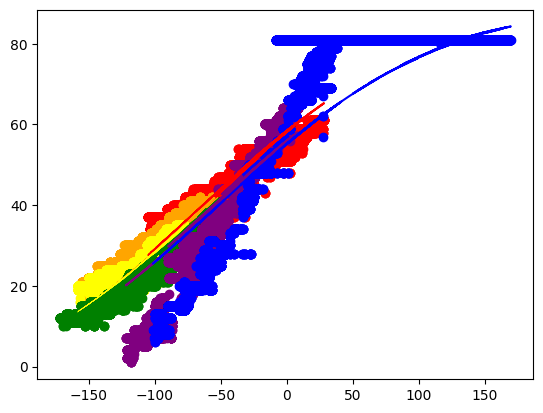

In [96]:
import matplotlib.pyplot as plt 

ten_thirty = int(datetime.datetime.strptime(f"{date} 10:30", "%Y-%m-%d %H:%M").timestamp())
eleven_thirty = int(datetime.datetime.strptime(f"{date} 11:30", "%Y-%m-%d %H:%M").timestamp())
twleve_thirty = int(datetime.datetime.strptime(f"{date} 12:30", "%Y-%m-%d %H:%M").timestamp())
one_thirty = int(datetime.datetime.strptime(f"{date} 13:30", "%Y-%m-%d %H:%M").timestamp())
two_thirty = int(datetime.datetime.strptime(f"{date} 14:30", "%Y-%m-%d %H:%M").timestamp())
three_thirty = int(datetime.datetime.strptime(f"{date} 15:30", "%Y-%m-%d %H:%M").timestamp())
four = int(datetime.datetime.strptime(f"{date} 16:00", "%Y-%m-%d %H:%M").timestamp())

ten = cdf[(cdf.ts >= ten_thirty) & (cdf.ts <= eleven_thirty)]
ten = get_cdf_with_params(ten, params)
plt.scatter(ten.spy_diff_from_threshold, ten.yes_bid_price, color ='red')
plt.plot(ten.spy_diff_from_threshold, 100*ten.sigmoid, color ='red')
eleven = cdf[(cdf.ts >= eleven_thirty) & (cdf.ts <= twleve_thirty)]
eleven = get_cdf_with_params(eleven, params)
plt.scatter(eleven.spy_diff_from_threshold, eleven.yes_bid_price, color ='orange')
plt.plot(eleven.spy_diff_from_threshold, 100*eleven.sigmoid, color ='orange')
twelve = cdf[(cdf.ts >= twleve_thirty) & (cdf.ts <= one_thirty)]
twelve = get_cdf_with_params(twelve, params)
plt.scatter(twelve.spy_diff_from_threshold, twelve.yes_bid_price, color ='yellow')
plt.plot(twelve.spy_diff_from_threshold, 100*twelve.sigmoid, color = "yellow")
one = cdf[(cdf.ts >= one_thirty) & (cdf.ts <= two_thirty)]
one = get_cdf_with_params(one, params)
plt.scatter(one.spy_diff_from_threshold, one.yes_bid_price, color ='green')
plt.plot(one.spy_diff_from_threshold, 100*one.sigmoid, color = "green")
two = cdf[(cdf.ts >= two_thirty) & (cdf.ts <= three_thirty)]
two = get_cdf_with_params(two, params)
plt.scatter(two.spy_diff_from_threshold, two.yes_bid_price, color ='purple')
plt.plot(two.spy_diff_from_threshold, 100*two.sigmoid, color = "purple")
three = cdf[(cdf.ts >= three_thirty) & (cdf.ts <= four)]
three = get_cdf_with_params(three, params)
plt.scatter(three.spy_diff_from_threshold, three.yes_bid_price, color ='blue')
plt.plot(three.spy_diff_from_threshold, 100*three.sigmoid, color = "blue")
plt.show()

In [79]:
cdf

,ts,spy_price,yes_bid_price,yes_bid_qty,yes_ask_price,yes_ask_qty,spy_diff_from_threshold,spy_price_expanding_std_dev
6618,1.701355e+09,45550.0,61.0,125.0,65.0,50.0,44.2,NaN
6619,1.701355e+09,45550.0,61.0,125.0,65.0,50.0,44.2,0.000000
6620,1.701355e+09,45550.0,61.0,125.0,65.0,50.0,44.2,0.000000
6621,1.701355e+09,45550.0,61.0,125.0,65.0,50.0,44.2,0.000000
6622,1.701355e+09,45550.0,61.0,125.0,65.0,50.0,44.2,0.000000
...,...,...,...,...,...,...,...,...
223918,1.701378e+09,45631.0,81.0,125.0,95.0,100.0,125.2,76.562518
223919,1.701378e+09,45631.0,81.0,125.0,95.0,100.0,125.2,76.563068
223920,1.701378e+09,45631.0,81.0,125.0,95.0,100.0,125.2,76.563617
223921,1.701378e+09,45631.0,81.0,125.0,95.0,100.0,125.2,76.564167


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

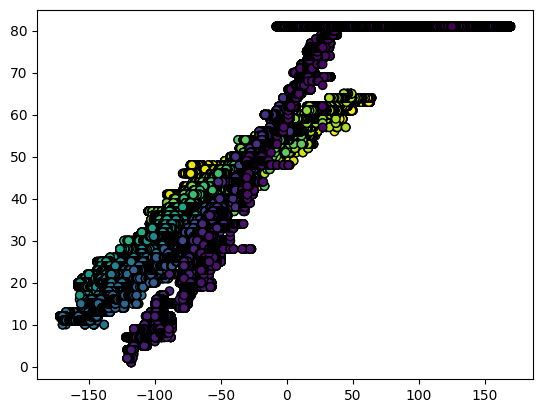

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

cdf['ts_diff'] = close_time_unix - cdf['ts'] 

# Normalize 'ts' values between 0 and 1
norm = Normalize(vmin=cdf['ts_diff'].min(), vmax=cdf['ts_diff'].max())

# Create a scalar map to map normalized 'ts_diff' values to colors
sm = ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])

# Plot scatter plot with color gradient
plt.scatter(
    cdf['spy_diff_from_threshold'],
    cdf['yes_bid_price'],
    c=sm.to_rgba(cdf['ts_diff']),
    marker='o',
    edgecolors='black'
)

# Add colorbar
cbar = plt.colorbar(sm, label='ts_diff')
cbar.set_label('ts_diff', rotation=270, labelpad=15)

# Add labels and title
plt.xlabel('spy_diff_from_threshold')
plt.ylabel('yes_bid_price')
plt.title('Scatter Plot with Color Gradient based on ts_diff')

# Show the plot
plt.show()